In [22]:
import os
import numpy as np
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import datasets, transforms, models
from tqdm import tqdm
import time

In [23]:
DATASET_DIR = "/kaggle/input/recon-p2-cnn-filtrado"   
IMG_SIZE = 224
BATCH_SIZE = 64 #Antes 32 
RANDOM_STATE = 42

print("Ruta dataset:", DATASET_DIR)
assert os.path.exists(DATASET_DIR), "No se encontró la carpeta del dataset balanceado."

Ruta dataset: /kaggle/input/recon-p2-cnn-filtrado


In [24]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1)
])

test_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [25]:
dataset_full = datasets.ImageFolder(root=DATASET_DIR, transform=test_transforms)
classes = dataset_full.classes
num_classes = len(classes)
labels = np.array([s[1] for s in dataset_full.samples])
print("Clases detectadas:", classes)
print("Cantidad total de imágenes:", len(dataset_full))

Clases detectadas: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
Cantidad total de imágenes: 27546


In [26]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_STATE)
train_idx, temp_idx = next(sss.split(np.zeros(len(labels)), labels))
labels_temp = labels[temp_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_STATE)
val_idx, test_idx = next(sss2.split(np.zeros(len(labels_temp)), labels_temp))

train_idx = np.array(train_idx)
val_idx = np.array(temp_idx[val_idx])
test_idx = np.array(temp_idx[test_idx])

print(f"Tamaño train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")

Tamaño train: 19282, val: 4132, test: 4132


In [27]:
train_dataset = Subset(dataset_full, train_idx)
val_dataset = Subset(dataset_full, val_idx)
test_dataset = Subset(dataset_full, test_idx)

In [28]:
train_labels = [dataset_full.samples[i][1] for i in train_idx]
class_counts = Counter(train_labels)
class_sample_count = [class_counts[i] for i in range(num_classes)]
print("Conteos en train por clase:", class_sample_count)

# Pesos inversos a la frecuencia
weights = [1.0 / class_sample_count[dataset_full.samples[i][1]] for i in train_idx]
sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)

# Calcular class weights para la loss
total = sum(class_sample_count)
class_weights = [total / (num_classes * c) for c in class_sample_count]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print("Pesos para la función de pérdida:", class_weights)

Conteos en train por clase: [4200, 4208, 7134, 3740]
Pesos para la función de pérdida: [1.1477380952380953, 1.1455560836501901, 0.6757078777684329, 1.288903743315508]


In [29]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("DataLoaders creados con éxito.")

DataLoaders creados con éxito.


Batch shape: torch.Size([64, 3, 224, 224])
Etiquetas en batch: ['Lung_Opacity', 'Viral Pneumonia', 'Normal', 'Normal', 'COVID', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia']


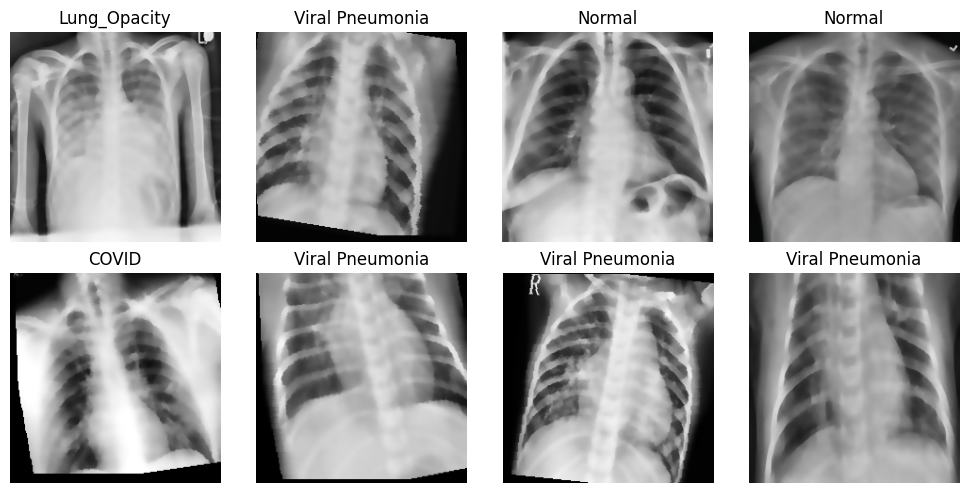

In [30]:
# Visualización rápida de una muestra del DataLoader

batch = next(iter(train_loader))
imgs, labs = batch
print("Batch shape:", imgs.shape)
print("Etiquetas en batch:", [classes[i] for i in labs[:8]])

plt.figure(figsize=(10,5))
for i in range(8):
    img = imgs[i].permute(1,2,0).numpy()
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title(classes[labs[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Definición del modelo CNN (ResNet18 con Fine-Tuning Parcial)
## -------------------------------------------------------------
## Se usa Transfer Learning a partir de la arquitectura ResNet18 preentrenada en ImageNet.
## Se congelan las capas convolucionales base (feature extractor) y se reemplaza la capa final (fully connected) por una nueva con 4 salidas (nuestras clases).

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entrenando en: {device}")

num_classes = len(classes)  # debería ser 4

# Cargar modelo ResNet18 con pesos preentrenados
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelar todas las capas convolucionales
for param in model.parameters():
    param.requires_grad = False

# Reemplazar la capa final (FC) por una nueva entrenable
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

model = model.to(device)
print(model)

Entrenando en: cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

In [32]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # solo entrena la capa final
num_epochs = 25  

# Loop de entrenamiento

In [33]:
# CELDA 18 — Entrenamiento principal
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0.0
best_model_path = "best_resnet18.pth"

for epoch in range(num_epochs):
    print(f"\nÉpoca {epoch+1}/{num_epochs}")
    model.train()
    running_loss, running_corrects = 0.0, 0
    total = 0

    # Entrenamiento
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())

    # Validación
    model.eval()
    val_loss, val_corrects, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_corrects.double() / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc.item())
    #train_f1 = f1_score(train_labels_all, train_preds_all, average='macro')
    #val_f1 = f1_score(val_labels_all, val_preds_all, average='macro')

    print(f"Entrenamiento -> Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
    print(f"Validación -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Guardar mejor modelo
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print("Modelo mejorado guardado.")



Época 1/25


100%|██████████| 302/302 [00:35<00:00,  8.57it/s]


Entrenamiento -> Loss: 0.5669, Acc: 0.7561
Validación -> Loss: 0.4470, Acc: 0.8163
Modelo mejorado guardado.

Época 2/25


100%|██████████| 302/302 [00:35<00:00,  8.58it/s]


Entrenamiento -> Loss: 0.4198, Acc: 0.8184
Validación -> Loss: 0.3782, Acc: 0.8533
Modelo mejorado guardado.

Época 3/25


100%|██████████| 302/302 [00:35<00:00,  8.62it/s]


Entrenamiento -> Loss: 0.3919, Acc: 0.8334
Validación -> Loss: 0.3692, Acc: 0.8449

Época 4/25


100%|██████████| 302/302 [00:35<00:00,  8.59it/s]


Entrenamiento -> Loss: 0.3763, Acc: 0.8395
Validación -> Loss: 0.3651, Acc: 0.8470

Época 5/25


100%|██████████| 302/302 [00:33<00:00,  8.89it/s]


Entrenamiento -> Loss: 0.3627, Acc: 0.8445
Validación -> Loss: 0.3573, Acc: 0.8463

Época 6/25


100%|██████████| 302/302 [00:33<00:00,  8.90it/s]


Entrenamiento -> Loss: 0.3479, Acc: 0.8510
Validación -> Loss: 0.3427, Acc: 0.8553
Modelo mejorado guardado.

Época 7/25


100%|██████████| 302/302 [00:34<00:00,  8.88it/s]


Entrenamiento -> Loss: 0.3441, Acc: 0.8517
Validación -> Loss: 0.3719, Acc: 0.8175

Época 8/25


100%|██████████| 302/302 [00:34<00:00,  8.77it/s]


Entrenamiento -> Loss: 0.3227, Acc: 0.8575
Validación -> Loss: 0.3558, Acc: 0.8485

Época 9/25


100%|██████████| 302/302 [00:34<00:00,  8.82it/s]


Entrenamiento -> Loss: 0.3178, Acc: 0.8605
Validación -> Loss: 0.3253, Acc: 0.8671
Modelo mejorado guardado.

Época 10/25


100%|██████████| 302/302 [00:33<00:00,  8.90it/s]


Entrenamiento -> Loss: 0.3261, Acc: 0.8578
Validación -> Loss: 0.3265, Acc: 0.8562

Época 11/25


100%|██████████| 302/302 [00:34<00:00,  8.82it/s]


Entrenamiento -> Loss: 0.3061, Acc: 0.8654
Validación -> Loss: 0.3432, Acc: 0.8485

Época 12/25


100%|██████████| 302/302 [00:34<00:00,  8.81it/s]


Entrenamiento -> Loss: 0.3009, Acc: 0.8673
Validación -> Loss: 0.3605, Acc: 0.8555

Época 13/25


100%|██████████| 302/302 [00:34<00:00,  8.86it/s]


Entrenamiento -> Loss: 0.2994, Acc: 0.8693
Validación -> Loss: 0.3388, Acc: 0.8635

Época 14/25


100%|██████████| 302/302 [00:34<00:00,  8.81it/s]


Entrenamiento -> Loss: 0.2936, Acc: 0.8708
Validación -> Loss: 0.3080, Acc: 0.8773
Modelo mejorado guardado.

Época 15/25


100%|██████████| 302/302 [00:34<00:00,  8.80it/s]


Entrenamiento -> Loss: 0.2909, Acc: 0.8732
Validación -> Loss: 0.3505, Acc: 0.8424

Época 16/25


100%|██████████| 302/302 [00:35<00:00,  8.59it/s]


Entrenamiento -> Loss: 0.2877, Acc: 0.8730
Validación -> Loss: 0.3260, Acc: 0.8739

Época 17/25


100%|██████████| 302/302 [00:34<00:00,  8.84it/s]


Entrenamiento -> Loss: 0.2787, Acc: 0.8757
Validación -> Loss: 0.3291, Acc: 0.8630

Época 18/25


100%|██████████| 302/302 [00:34<00:00,  8.82it/s]


Entrenamiento -> Loss: 0.2694, Acc: 0.8836
Validación -> Loss: 0.3251, Acc: 0.8754

Época 19/25


100%|██████████| 302/302 [00:34<00:00,  8.71it/s]


Entrenamiento -> Loss: 0.2775, Acc: 0.8789
Validación -> Loss: 0.3046, Acc: 0.8766

Época 20/25


100%|██████████| 302/302 [00:33<00:00,  9.02it/s]


Entrenamiento -> Loss: 0.2604, Acc: 0.8849
Validación -> Loss: 0.3027, Acc: 0.8734

Época 21/25


100%|██████████| 302/302 [00:34<00:00,  8.86it/s]


Entrenamiento -> Loss: 0.2649, Acc: 0.8853
Validación -> Loss: 0.3083, Acc: 0.8708

Época 22/25


100%|██████████| 302/302 [00:35<00:00,  8.57it/s]


Entrenamiento -> Loss: 0.2726, Acc: 0.8807
Validación -> Loss: 0.3219, Acc: 0.8650

Época 23/25


100%|██████████| 302/302 [00:34<00:00,  8.88it/s]


Entrenamiento -> Loss: 0.2526, Acc: 0.8863
Validación -> Loss: 0.3207, Acc: 0.8688

Época 24/25


100%|██████████| 302/302 [00:34<00:00,  8.80it/s]


Entrenamiento -> Loss: 0.2559, Acc: 0.8854
Validación -> Loss: 0.3345, Acc: 0.8533

Época 25/25


100%|██████████| 302/302 [00:34<00:00,  8.65it/s]


Entrenamiento -> Loss: 0.2396, Acc: 0.8938
Validación -> Loss: 0.3066, Acc: 0.8761


# Gráficas de pérdida y accuracy

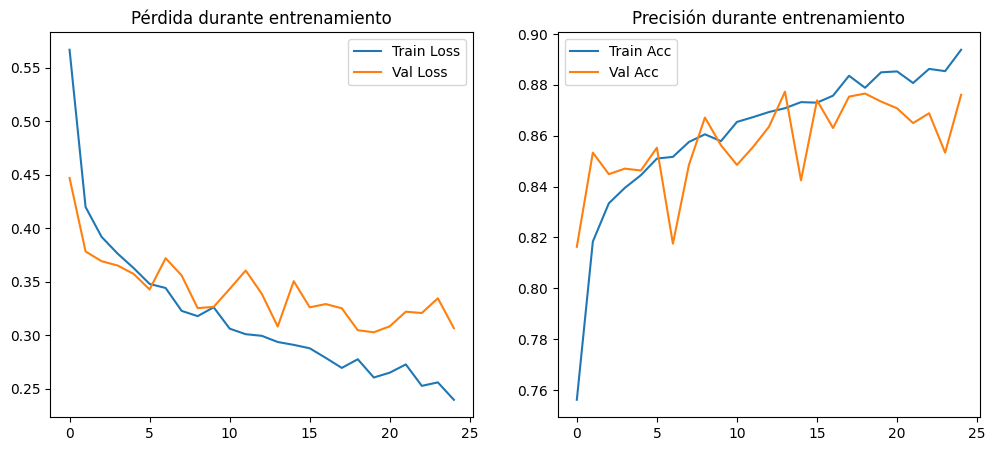

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title("Pérdida durante entrenamiento")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend(); plt.title("Precisión durante entrenamiento")
plt.show()

# Evaluación en el conjunto de prueba


Reporte de clasificación:

                 precision    recall  f1-score   support

          COVID       0.89      0.85      0.87       900
   Lung_Opacity       0.76      0.86      0.81       902
         Normal       0.89      0.85      0.87      1529
Viral Pneumonia       0.97      0.96      0.96       801

       accuracy                           0.87      4132
      macro avg       0.88      0.88      0.88      4132
   weighted avg       0.88      0.87      0.87      4132



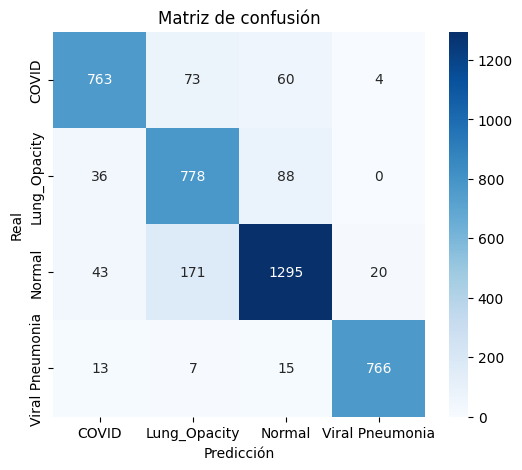

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Cargar mejor modelo
model.load_state_dict(torch.load(best_model_path))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Reporte y matriz de confusión
print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.show()


In [36]:
torch.save(model.state_dict(), "resnet18_finetuned_filtered.pth")
print("Modelo final guardado como resnet18_finetuned_filtered.pth")

Modelo final guardado como resnet18_finetuned_filtered.pth


In [37]:
# Obtener el tamaño del modelo
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total de parámetros: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

import os
torch.save(model.state_dict(), "temp_model.pth")
print(f"Tamaño del archivo del modelo: {os.path.getsize('temp_model.pth') / 1e6:.2f} MB")

Total de parámetros: 11,308,868
Parámetros entrenables: 132,356
Tamaño del archivo del modelo: 45.32 MB


# Mapas de calor

Usando capa: layer4.1.conv2


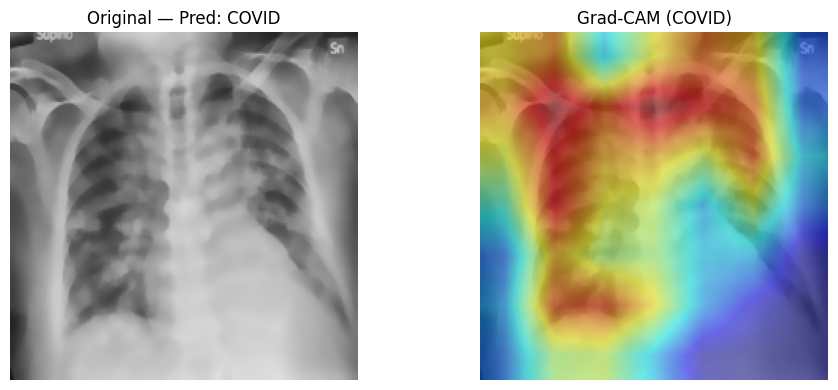

Usando capa: layer4.1.conv2


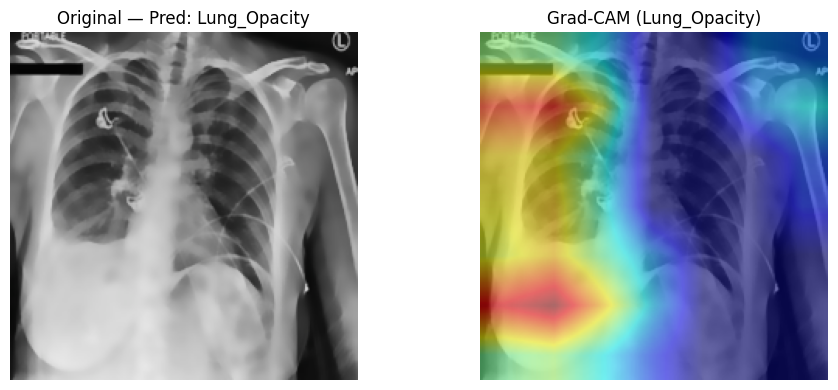

Usando capa: layer4.1.conv2


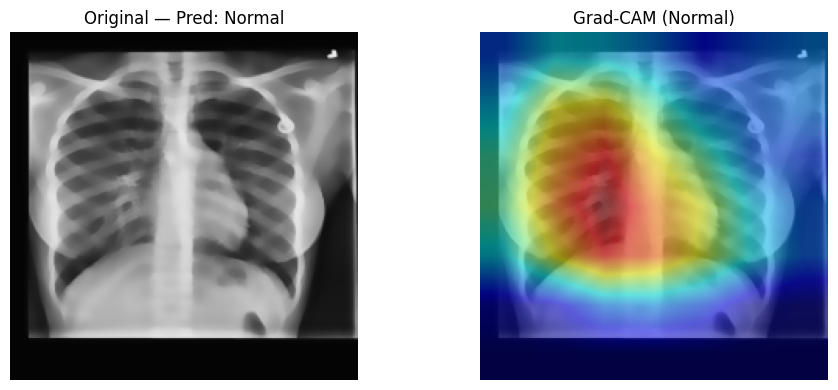

Usando capa: layer4.1.conv2


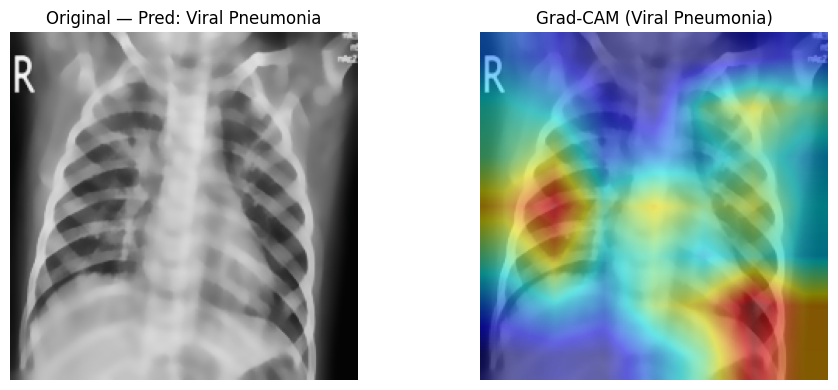

In [42]:
# CELDA — GradCAM para visualizar regiones activadas
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms

def generate_gradcam(model, image_tensor, class_idx=None, device='cuda'):
    model.eval()
    model.to(device)

    # Buscar automáticamente la última capa convolucional (por nombre)
    target_layer = None
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            target_layer = name  # guarda la última conv
    print(f"Usando capa: {target_layer}")

    activations = {}
    gradients = {}

    def forward_hook(module, inp, out):
        activations['value'] = out.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    # Registrar hooks correctamente en la capa encontrada
    layer = dict([*model.named_modules()])[target_layer]
    forward_handle = layer.register_forward_hook(forward_hook)
    backward_handle = layer.register_backward_hook(backward_hook)

    # Forward
    output = model(image_tensor)
    if class_idx is None:
        class_idx = output.argmax(dim=1).item()

    # Backward
    model.zero_grad()
    class_score = output[0, class_idx]
    class_score.backward()

    # Retirar hooks (buena práctica)
    forward_handle.remove()
    backward_handle.remove()

    # Verificación
    if 'value' not in gradients or 'value' not in activations:
        raise RuntimeError("No se capturaron gradientes o activaciones — revisa layer_name o hooks.")

    grads = gradients['value']
    acts = activations['value']
    pooled_grads = torch.mean(grads, dim=[0, 2, 3])

    for i in range(acts.shape[1]):
        acts[:, i, :, :] *= pooled_grads[i]

    heatmap = torch.mean(acts, dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)
    return heatmap.cpu().numpy(), class_idx

def show_gradcam_on_image(img_path, model, transform, classes, device='cuda'):
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    heatmap, class_idx = generate_gradcam(model, input_tensor, device=device)
    pred_class = classes[class_idx]

    img_np = np.array(img)
    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR), 0.5, heatmap_color, 0.5, 0)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Original — Pred: {pred_class}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM ({pred_class})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
# Visualizar mapa de calor

image_path = "/kaggle/input/recon-p2-cnn-filtrado/COVID/COVID-10.png"  
model.load_state_dict(torch.load("resnet18_finetuned_filtered.pth"))
model = model.to(device)

show_gradcam_on_image(
    img_path=image_path,
    model=model,
    transform=test_transforms,
    classes=classes,
    device=device
)

image_path2 = "/kaggle/input/recon-p2-cnn-filtrado/Lung_Opacity/Lung_Opacity-100.png"  

show_gradcam_on_image(
    img_path=image_path2,
    model=model,
    transform=test_transforms,
    classes=classes,
    device=device
)

image_path3 = "/kaggle/input/recon-p2-cnn-filtrado/Normal/Normal-1.png"  
show_gradcam_on_image(
    img_path=image_path3,
    model=model,
    transform=test_transforms,
    classes=classes,
    device=device
)

image_path4 = "/kaggle/input/recon-p2-cnn-filtrado/Viral Pneumonia/Viral Pneumonia-1.png"  
show_gradcam_on_image(
    img_path=image_path4,
    model=model,
    transform=test_transforms,
    classes=classes,
    device=device
)